<a href="https://colab.research.google.com/github/VenGr0/Image_Search/blob/main/Image_Search_with_CLIP_and_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Установка зависимостей**

In [1]:
!pip install torch torchvision transformers faiss-cpu matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 35.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

**Код проекта**

Vectorizing images...
Text query: A photo of a car
Finding nearest images...
Displaying results...


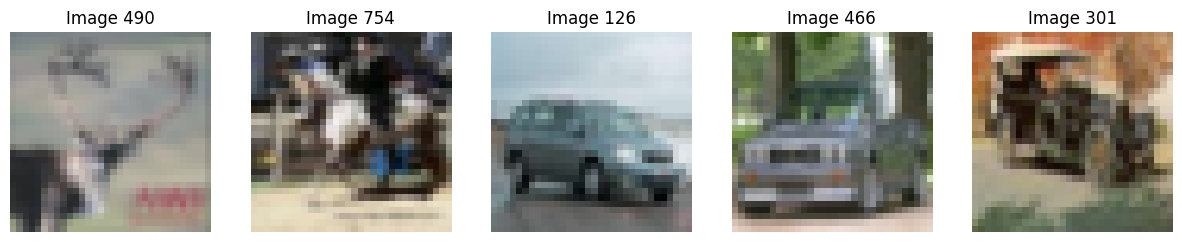

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image
import faiss
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# Ваш токен Hugging Face
HF_TOKEN = "ваш_токен_здесь"

# Загрузка предобученной модели ResNet и CLIP
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Используем новый синтаксис для загрузки весов
resnet.eval()

# Использование HF_TOKEN для загрузки модели CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", token=HF_TOKEN)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", token=HF_TOKEN)

# Загрузка датасета CIFAR-10
cifar10 = CIFAR10(root='./data', train=True, download=True)

# Преобразование изображений для ResNet
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Векторизация изображений CIFAR-10 с помощью ResNet
def vectorize_images(dataset, max_samples=1000):
    vectors = []
    for i, (img, _) in enumerate(dataset):
        if i >= max_samples:  # Ограничиваем количество изображений для ускорения
            break
        img = preprocess(img).unsqueeze(0)
        with torch.no_grad():
            vector = resnet(img).squeeze().numpy()
        vectors.append(vector)
    return np.array(vectors)

# Векторизация текста с помощью CLIP
def vectorize_text(text):
    inputs = clip_processor(text=text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        text_vector = clip_model.get_text_features(**inputs).squeeze().numpy()
    return text_vector

# Поиск ближайших изображений с помощью FAISS
def find_nearest_images(text_vector, image_vectors, k=5):
    # Приводим векторы изображений к размерности текстового вектора (512)
    if image_vectors.shape[1] != text_vector.shape[0]:
        # Используем PCA для уменьшения размерности
        pca = faiss.PCAMatrix(image_vectors.shape[1], text_vector.shape[0])
        pca.train(image_vectors)
        image_vectors = pca.apply(image_vectors)

    # Создаем индекс FAISS
    index = faiss.IndexFlatL2(text_vector.shape[0])
    index.add(image_vectors)

    # Ищем ближайшие изображения
    distances, indices = index.search(np.array([text_vector]), k)
    return indices[0]

# Функция для отображения изображений
def show_images(indices, dataset):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img)
        plt.title(f"Image {idx}")
        plt.axis('off')
    plt.show()

# Основная функция
def main():
    # Векторизация изображений CIFAR-10 (ограничиваем количество для ускорения)
    print("Vectorizing images...")
    image_vectors = vectorize_images(cifar10, max_samples=1000)  # Ограничиваем 1000 изображений

    # Пример текстового запроса
    text_query = "A photo of the car"
    print(f"Text query: {text_query}")
    text_vector = vectorize_text(text_query)

    # Поиск ближайших изображений
    print("Finding nearest images...")
    nearest_indices = find_nearest_images(text_vector, image_vectors, k=5)

    # Вывод результатов
    print("Displaying results...")
    show_images(nearest_indices, cifar10)

if __name__ == "__main__":
    main()